# Setup Paths

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir 'tensorflow-great-barrier-reef'

In [ ]:
# unzip datasets from google drive
TF_ZIP_PATH = '/content/gdrive/MyDrive/tensorflow-great-barrier-reef'
TF_DIR_PATH = '/content/tensorflow-great-barrier-reef'
!unzip -u {TF_ZIP_PATH} -d {TF_DIR_PATH}
print('Successfully unzipping tensorflow-great-barrier-reef')

In [ ]:
from google.colab import files

uploaded = files.upload()

# upload generate_tfrecord.py
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving generate_tfrecord.py to generate_tfrecord.py
User uploaded file "generate_tfrecord.py" with length 4471 bytes


In [ ]:
CUSTOM_MODEL_NAME = 'efficientdet_d0' 
PRETRAINED_MODEL_NAME = 'efficientdet_d0_coco17_tpu-32'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz'
TF_RECORD_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [ ]:
paths = {
    'WORKSPACE_PATH': os.path.join('tensorflow-great-barrier-reef', 'workspace'),
    'APIMODEL_PATH': os.path.join('tensorflow-great-barrier-reef', 'models'),
    'ANNOTATION_PATH': os.path.join('tensorflow-great-barrier-reef', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('tensorflow-great-barrier-reef', 'train_images'),
    'MODEL_PATH': os.path.join('tensorflow-great-barrier-reef', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('tensorflow-great-barrier-reef', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('tensorflow-great-barrier-reef', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('tensorflow-great-barrier-reef', 'workspace','models',CUSTOM_MODEL_NAME, 'export'),  
    'PROTOC_PATH':os.path.join('tensorflow-great-barrier-reef','protoc')
 }

In [ ]:
files = {
    'PIPELINE_CONFIG':os.path.join('tensorflow-great-barrier-reef', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD': os.path.join(paths['ANNOTATION_PATH'], TF_RECORD_NAME),
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [ ]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

In [ ]:
!mv {TF_RECORD_NAME} {paths['ANNOTATION_PATH']}
!mv /content/tensorflow-great-barrier-reef/train.csv {paths['ANNOTATION_PATH']}

# Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [ ]:
if os.name=='nt':
    !pip install wget
    import wget

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

Cloning into 'tensorflow-great-barrier-reef/models'...
remote: Enumerating objects: 67051, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 67051 (delta 8), reused 15 (delta 8), pack-reused 67035
Receiving objects: 100% (67051/67051), 576.29 MiB | 35.83 MiB/s, done.
Resolving deltas: 100% (47067/47067), done.


In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd tensorflow-great-barrier-reef/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd tensorflow-great-barrier-reef/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd tensorflow-great-barrier-reef/models/research/slim && pip install -e . 

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

In [ ]:
!pip install tensorflow --upgrade

In [ ]:
!pip uninstall protobuf matplotlib -y
!pip install protobuf matplotlib==3.2

In [ ]:
import object_detection

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

# Create Label Map

In [ ]:
label_map_str = """item {
  id: 1
  name: 'COTS'
}"""

with open(files['LABELMAP'], 'w') as f:
  f.write(label_map_str)

# Create TF Records

In [ ]:
import pandas as pd
import ast

cwl = '/content/tensorflow-great-barrier-reef/workspace/annotations'
data_df = pd.read_csv(cwl + '/train.csv')
data_df['image_path'] = '/content/tensorflow-great-barrier-reef/train_images/video_' + \
                        data_df['video_id'].astype(str) + '/' + data_df[
    'video_frame'].astype(str) + '.jpg'
data_df["annotations"] = data_df["annotations"].apply(ast.literal_eval)
data_df
len(data_df)

23501

In [ ]:
training_ratio = 0.8
split_index = int(training_ratio * len(data_df))
print(split_index)
while data_df.iloc[split_index - 1].sequence == data_df.iloc[split_index].sequence:
    split_index += 1
train_df = data_df.iloc[:split_index].sample(frac=1).reset_index(drop=True)
test_df = data_df.iloc[split_index:].sample(frac=1).reset_index(drop=True)
train_df.head()
test_df.head()

print(len(train_df))
print(len(test_df))

18800
19265
4236


In [ ]:
train_positive_count = len(train_df[train_df.annotations.map(tuple) != tuple([])])
test_positive_count = len(test_df[test_df.annotations.map(tuple) != tuple([])])

print(train_positive_count)
print(test_positive_count)
print('Training ratio (all samples):',
      float(len(train_df)) / (len(train_df) + len(test_df)))
print('Training ratio (positive samples):',
      float(train_positive_count) / (train_positive_count + test_positive_count))

4271
648
Training ratio (all samples): 0.8197523509637887
Training ratio (positive samples): 0.868265907704818


In [ ]:
train_df = train_df[train_df.annotations.map(tuple) != tuple([])].reset_index()
print('Number of positive images used for training:', len(train_df))
test_df = test_df[test_df.annotations.map(tuple) != tuple([])].reset_index()
print('Number of positive images used for validation:', len(test_df))
train_df.head()
test_df.head()

Number of positive images used for training: 4271
Number of positive images used for validation: 648


,index,video_id,sequence,video_frame,sequence_frame,image_id,annotations,image_path
0,9,2,22643,6361,998,2-6361,"[{'x': 187, 'y': 84, 'width': 33, 'height': 28}]",/content/tensorflow-great-barrier-reef/train_i...
1,17,2,22643,5805,442,2-5805,"[{'x': 850, 'y': 40, 'width': 54, 'height': 36...",/content/tensorflow-great-barrier-reef/train_i...
2,26,2,22643,5421,58,2-5421,"[{'x': 194, 'y': 403, 'width': 49, 'height': 47}]",/content/tensorflow-great-barrier-reef/train_i...
3,36,2,29859,7991,219,2-7991,"[{'x': 412, 'y': 486, 'width': 38, 'height': 35}]",/content/tensorflow-great-barrier-reef/train_i...
4,42,2,29859,8860,1088,2-8860,"[{'x': 473, 'y': 501, 'width': 49, 'height': 39}]",/content/tensorflow-great-barrier-reef/train_i...


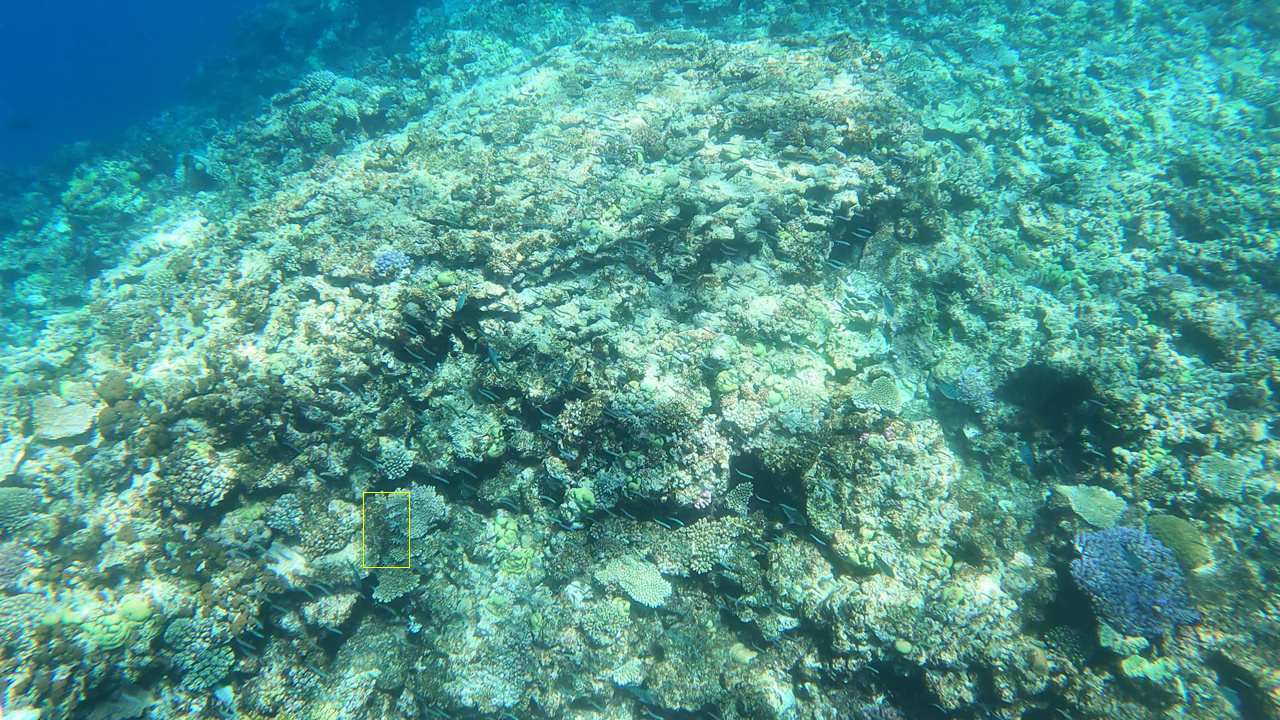

In [ ]:
import IPython
from PIL import Image, ImageDraw
import json
import io

def image_with_annotation(video_id, video_frame, data_df, image_path):
    """Visualize annotations of a given image."""
    full_path = os.path.join(image_path, os.path.join(f'video_{video_id}', f'{video_frame}.jpg'))
    image = Image.open(full_path)
    draw = ImageDraw.Draw(image)

    rows = data_df[(data_df.video_id == video_id) & (data_df.video_frame == video_frame)]
    for _, row in rows.iterrows():
        for annotation in row.annotations:
            draw.rectangle((
                annotation['x'], 
                annotation['y'],
                (annotation['x'] + annotation['width']), 
                (annotation['y'] + annotation['height']),
                ), outline=(255, 255, 0))
        
    buf = io.BytesIO()
    image.save(buf, 'PNG')
    data = buf.getvalue()

    return data

# Test visualization of a randomly selected image
test_index = 38
video_id = train_df.iloc[test_index].video_id
video_frame = train_df.iloc[test_index].video_frame
IPython.display.Image(image_with_annotation(video_id, video_frame, data_df, paths['IMAGE_PATH']))

In [ ]:
%run {files['TF_RECORD']}

In [ ]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

# Update Config For Transfer Learning

In [ ]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [ ]:
# config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [ ]:
# pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
# with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
#     proto_str = f.read()                                                                                                                                                                                                                                          
#     text_format.Merge(proto_str, pipeline_config)  


In [ ]:
from string import Template

config_file_template = """
# SSD with EfficientNet-b0 + BiFPN feature extractor,
# shared box predictor and focal loss (a.k.a EfficientDet-d0).
# See EfficientDet, Tan et al, https://arxiv.org/abs/1911.09070
# See Lin et al, https://arxiv.org/abs/1708.02002
# Initialized from an EfficientDet-D0 checkpoint.
#
# Train on GPU

model {
  ssd {
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    num_classes: 1
    add_background_class: false
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    encode_background_as_zeros: true
    anchor_generator {
      multiscale_anchor_generator {
        min_level: 3
        max_level: 7
        anchor_scale: 4.0
        aspect_ratios: [1.0, 2.0, 0.5]
        scales_per_octave: 3
      }
    }
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 1280
        max_dimension: 1280
        pad_to_max_dimension: true
        }
    }
    box_predictor {
      weight_shared_convolutional_box_predictor {
        depth: 64
        class_prediction_bias_init: -4.6
        conv_hyperparams {
          force_use_bias: true
          activation: SWISH
          regularizer {
            l2_regularizer {
              weight: 0.00004
            }
          }
          initializer {
            random_normal_initializer {
              stddev: 0.01
              mean: 0.0
            }
          }
          batch_norm {
            scale: true
            decay: 0.99
            epsilon: 0.001
          }
        }
        num_layers_before_predictor: 3
        kernel_size: 3
        use_depthwise: true
      }
    }
    feature_extractor {
      type: 'ssd_efficientnet-b0_bifpn_keras'
      bifpn {
        min_level: 3
        max_level: 7
        num_iterations: 3
        num_filters: 64
      }
      conv_hyperparams {
        force_use_bias: true
        activation: SWISH
        regularizer {
          l2_regularizer {
            weight: 0.00004
          }
        }
        initializer {
          truncated_normal_initializer {
            stddev: 0.03
            mean: 0.0
          }
        }
        batch_norm {
          scale: true,
          decay: 0.99,
          epsilon: 0.001,
        }
      }
    }
    loss {
      classification_loss {
        weighted_sigmoid_focal {
          alpha: 0.25
          gamma: 1.5
        }
      }
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    normalize_loss_by_num_matches: true
    normalize_loc_loss_by_codesize: true
    post_processing {
      batch_non_max_suppression {
        score_threshold: 1e-8
        iou_threshold: 0.5
        max_detections_per_class: 100
        max_total_detections: 100
      }
      score_converter: SIGMOID
    }
  }
}

train_config: {
  fine_tune_checkpoint: "tensorflow-great-barrier-reef/workspace/pre-trained-models/efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0"
  fine_tune_checkpoint_version: V2
  fine_tune_checkpoint_type: "detection"
  batch_size: 2
  sync_replicas: false
  startup_delay_steps: 0
  replicas_to_aggregate: 1
  use_bfloat16: false
  num_steps: $training_steps
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_scale_crop_and_pad_to_square {
      output_size: 1280
      scale_min: 0.5
      scale_max: 2.0
    }
  }
  optimizer {
    momentum_optimizer: {
      learning_rate: {
        cosine_decay_learning_rate {
          learning_rate_base: 5e-3
          total_steps: $training_steps
          warmup_learning_rate: 5e-4
          warmup_steps: $warmup_steps
        }
      }
      momentum_optimizer_value: 0.9
    }
    use_moving_average: false
  }
  max_number_of_boxes: 100
  unpad_groundtruth_tensors: false
}

train_input_reader: {
  label_map_path: "tensorflow-great-barrier-reef/workspace/annotations/label_map.pbtxt"
  tf_record_input_reader {
    input_path: "tensorflow-great-barrier-reef/workspace/annotations/train.record"
  }
}

eval_config: {
  metrics_set: "coco_detection_metrics"
  use_moving_averages: false
  batch_size: 2;
}

eval_input_reader: {
  label_map_path: "tensorflow-great-barrier-reef/workspace/annotations/label_map.pbtxt"
  shuffle: false
  num_epochs: 1
  tf_record_input_reader {
    input_path: "tensorflow-great-barrier-reef/workspace/annotations/test.record"
  }
}
"""

In [ ]:
TRAINING_STEPS = 20000
WARMUP_STEPS = 2000

pipeline = Template(config_file_template).substitute(
    training_steps=TRAINING_STEPS, warmup_steps=WARMUP_STEPS)

with open(files['PIPELINE_CONFIG'], 'w') as f:
    f.write(pipeline)

In [ ]:
# pipeline_config.model.ssd.num_classes = len(labels)
# pipeline_config.train_config.batch_size = 4
# pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
# pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
# pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
# pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
# pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
# pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]
# config_text = text_format.MessageToString(pipeline_config)                                                                                                                     

In [ ]:
# with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
#     f.write(config_text)   

# Train the Model

In [ ]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [ ]:
!pip uninstall --yes opencv-python
!pip install --yes opencv-python

Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --yes


In [ ]:
!{command}

2022-01-17 17:30:39.598679: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0117 17:30:39.626457 139911126030208 mirrored_strategy.py:376] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: None
I0117 17:30:39.639037 139911126030208 config_util.py:552] Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0117 17:30:39.639216 139911126030208 config_util.py:552] Maybe overwriting use_bfloat16: False
I0117 17:30:39.690466 139911126030208 ssd_efficientnet_bifpn_feature_extractor.py:146] EfficientDet EfficientNet backbone version: efficientnet-b0
I0117 17:30:39.690592 139911126030208 ssd_efficientnet_bifpn_feature_extractor.py:147] 

# Evaluate the Model

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])
print(command)

python tensorflow-great-barrier-reef/models/research/object_detection/model_main_tf2.py --model_dir=tensorflow-great-barrier-reef/workspace/models/efficientdet_d0 --pipeline_config_path=tensorflow-great-barrier-reef/workspace/models/efficientdet_d0/pipeline.config --checkpoint_dir=tensorflow-great-barrier-reef/workspace/models/efficientdet_d0


In [ ]:
!{command}

W0117 23:25:20.689172 139917258434432 model_lib_v2.py:1090] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0117 23:25:20.689408 139917258434432 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0117 23:25:20.689496 139917258434432 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0117 23:25:20.689587 139917258434432 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0117 23:25:20.689712 139917258434432 model_lib_v2.py:1111] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
2022-01-17 23:25:22.717421: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original confi

In [ ]:
!tensorboard --logdir=tensorflow-great-barrier-reef/workspace/models/my_ssd_mobnet/train --host localhost